**Importing the NHIS data into a pandas dataframe**

In [32]:
# The data was downloaded from IPUMS and then formatted into a STATA data file
# Importing necessary libraries for the entire project

import numpy as np
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt

# The rdd library allows us to calculate the optimal bandwidth to select our sample
from rdd import rdd

# Defining the filepath that contains the NHIS data, reading it in, and putting into a pandas dataframe

dtafile = r'C:\Users\devin\Documents\School\ECON6060FinalProject\NHIS2000.dta'
df = pd.read_stata(dtafile)

# Outputting a sample of the dataframe to make sure it loaded in correctly

print(df.tail())

# Putting the data into a SQLite database

con = sqlite3.connect(r'C:\Users\devin\Documents\School\ECON6060FinalProject\ProjectData.sqlite')
df.to_sql("initial_data", con, if_exists="replace")
con.close()

        year  serial  strata  psu         nhishid  hhweight     region  \
100613  2000   43301    5126    2  00002000072367      2491  Northeast   
100614  2000   43301    5126    2  00002000072367      2491  Northeast   
100615  2000   43301    5126    2  00002000072367      2491  Northeast   
100616  2000   43301    5126    2  00002000072367      2491  Northeast   
100617  2000   43301    5126    2  00002000072367      2491  Northeast   

        pernum           nhispid     hhx  ... mod10fwk vig10dmin  vig10fwk  \
100613       1  0020000723670101  072367  ...        0         0         0   
100614       2  0020000723670102  072367  ...        0         0         0   
100615       3  0020000723670103  072367  ...        0         0         0   
100616       4  0020000723670104  072367  ...        0         0         0   
100617       5  0020000723670105  072367  ...        0         0         0   

        strongfwk  bfhcan  bmhcan  fbnum fbnhcan fsnum  fsnhcan  
100613          0   

**Cleaning the data and creating necessary variables**

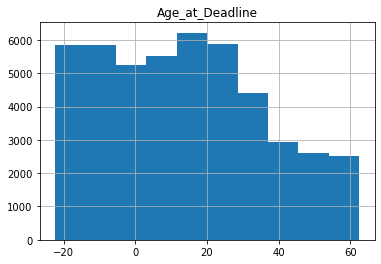

In [36]:
# Querying the database and limiting the sample to just women who have a birth
# year that isn't missing

con = sqlite3.connect(r'C:\Users\devin\Documents\School\ECON6060FinalProject\ProjectData.sqlite')
restricted = pd.read_sql_query("""SELECT * 
                               FROM initial_data 
                               WHERE sex = 'Female' AND birthyr < 2001""", con)
con.close()

# Creating dummy variables for region of residence at time of survey
restricted['Northeast'] = np.where(restricted['region'] == 'Northeast', 1, 0)

restricted['Midwest'] = np.where(restricted['region'] == 'North Central/Midwest', 1, 0)

restricted['South'] = np.where(restricted['region'] == 'South', 1, 0)

restricted['West'] = np.where(restricted['region'] == 'West', 1, 0)

# Checking if the dummies are mutually exclusive and exhaustive

assert (restricted['Northeast'] + restricted['Midwest'] + restricted['South'] + restricted['West']).eq(1).all() == 1

# Creating the age variable which will be used as the running variable for the regression discontinuity analysis
# It is calculated to be the age of the individual in July of 1978

restricted.loc[restricted['birthmo'] == 'January', 'birthmo_num'] = 1
restricted.loc[restricted['birthmo'] == 'February', 'birthmo_num'] = 2
restricted.loc[restricted['birthmo'] == 'March', 'birthmo_num'] = 3
restricted.loc[restricted['birthmo'] == 'April', 'birthmo_num'] = 4
restricted.loc[restricted['birthmo'] == 'May', 'birthmo_num'] = 5
restricted.loc[restricted['birthmo'] == 'June', 'birthmo_num'] = 6
restricted.loc[restricted['birthmo'] == 'July', 'birthmo_num'] = 7
restricted.loc[restricted['birthmo'] == 'August', 'birthmo_num'] = 8
restricted.loc[restricted['birthmo'] == 'September', 'birthmo_num'] = 9
restricted.loc[restricted['birthmo'] == 'October', 'birthmo_num'] = 10
restricted.loc[restricted['birthmo'] == 'November', 'birthmo_num'] = 11
restricted.loc[restricted['birthmo'] == 'December', 'birthmo_num'] = 12

restricted['Age_at_Deadline'] = (1978 + (7/12)) - (restricted['birthyr'] + (restricted['birthmo_num'] / 12))

# Restricting the sample to only those with a birth month
    
restricted = restricted[restricted.birthmo != 'Unknown-refused']
restricted = restricted[restricted.birthmo != 'Unknown-not ascertained']
restricted = restricted[restricted.birthmo != "Unknown-don't know"]

hist = restricted.hist('Age_at_Deadline')

# Creating dummy variables for race and ethnicity

restricted['Hispanic'] = np.where(restricted['hispyn'] == 'Yes, of Hispanic ethnicity', 1, 0)

restricted['White'] = np.where(((restricted['racenew'] == 'White') & (restricted['Hispanic'] == 0)), 1, 0)

restricted['Black'] = np.where(((restricted['racenew'] == 'Black/African American') & (restricted['Hispanic'] == 0)), 1, 0)

restricted['Other'] = np.where(((restricted['Hispanic'] == 0) & (restricted['White'] == 0) & (restricted['Black'] == 0)), 1, 0)

# Checking if the dummies are mutually exclusive and exhaustive

assert (restricted['Hispanic'] + restricted['White'] + restricted['Black'] + restricted['Other']).eq(1).all() == 1

# Creating a dummy variable for if they were born in the US or not

restricted['US_born_dummy'] = np.where(restricted['usborn'] == 'Yes, born in U.S.', 1 , 0)

# Creating a dummy variable and a continuous variable for height

restricted['Exceptional_Height'] = np.where(restricted['height'] == \
                                            'Exceptionally short or tall (2019-forward: or sex is unknown)', 1, 0)

# Creating the lifestyle variables
    
    # Drinking
    
restricted['Drinker'] = np.where(restricted['alcstat1'] == 'Current drinker (1+ drinks past year)', 1, 0)

    # Smoking
    
restricted['Smoker'] = np.where(((restricted['smokestatus2'] == 'Current every day smoker') | \
                                 (restricted['smokestatus2'] == 'Current some day smoker')), 1, 0)

    # Exercise
    
        # Values of 997, 998, and 999 indicated unknown values, so these observations are dropped
    
restricted = restricted[restricted.mod10dmin < 997]

restricted = restricted[restricted.vig10dmin < 997]
    
restricted['moderate_exercise'] = restricted['mod10dmin'] * restricted['mod10fwk']

restricted['vigorous_exercise'] = restricted['vig10dmin'] * restricted['vig10fwk']

        # Values of 94 (less than once per week), 95 (never), and 96 (unable to do this activity) are treated as zeroes
        # I'm creating both a dummy variable (which takes a value of 1 if the respondent does any strength-increasing
        # exercises, and 0 if not) and a variable which contains the number of times the respondent does
        # strength-increasing exercises per week

restricted['strong_dummy'] = np.where(((restricted['strongfwk'] < 94) & (restricted['strongfwk'] > 0)), 1, 0)

restricted['strong_freq'] = restricted['strongfwk']
restricted.loc[restricted['strong_freq'] > 93, 'strong_freq'] = 0

# Creating dummy variables for family members' cancer history. Unknowns are treated as a "no" or 0

restricted['father_cancer'] = np.where(restricted['bfhcan'] == 'Yes', 1, 0)

restricted['mother_cancer'] = np.where(restricted['bmhcan'] == 'Yes', 1, 0)

# Creating variables for number of full siblings and how many have had cancer

restricted['number_of_brothers'] = restricted['fbnum']
restricted.loc[restricted['number_of_brothers'] > 95, 'number_of_brothers'] = 0

restricted['number_of_sisters'] = restricted['fsnum']
restricted.loc[restricted['number_of_sisters'] > 95, 'number_of_sisters'] = 0

**Calculating the difference in means and associated standard errors**

Optimal bandwidth :  2.690451648443031
   Hispanic_w    White_w   Black_w   Other_w  US_born_w  exc_height_w  \
0    534400.0  3743330.0  665339.0  269504.0  4443866.0      123262.0   
1    599930.0  4016543.0  687595.0  351415.0  4775830.0      143100.0   

   f_cancer_w  m_cancer_w  brothers_w  sisters_w  drinker_w  smoker_w  \
0    534369.0    462335.0   3746685.0  3732670.0  1569504.0  667926.0   
1    573448.0    468819.0   4439053.0  4306081.0  1882008.0  826950.0   

    moderate_w   vigorous_w  strong_d_w  strong_freq_w  sum_weights     N  
0  610886762.0  500977649.0    557037.0      2037729.0    5212573.0  1923  
1  540095332.0  611376054.0    604130.0      2175027.0    5655483.0  2058  
   Hispanic     White     Black     Other   US_born  exc_height  f_cancer  \
0  0.102521  0.718135  0.127641  0.051703  0.852528    0.023647  0.102515   
1  0.106079  0.710203  0.121580  0.062137  0.844460    0.025303  0.101397   

   m_cancer  brothers   sisters   Drinker    Smoker  Moderate

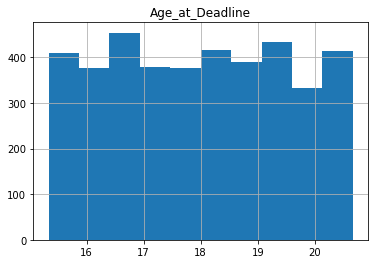

In [37]:
# Now that the variables are ready, it's time to run the regression discontinuity analysis and calculate sample means

# Start by calculating the optimal bandwidth

optimal_bandwidth = rdd.optimal_bandwidth(restricted['strong_freq'], restricted['Age_at_Deadline'], 18)
print('Optimal bandwidth : ', optimal_bandwidth)

# Restricting the sample to those in the optimal bandwidth

final = restricted[restricted['Age_at_Deadline'] < (18 + optimal_bandwidth)]
final = final[final['Age_at_Deadline'] > (18 - optimal_bandwidth)]

hist = final.hist('Age_at_Deadline')

# Calculating means for "baseline" attributes and outcomes for the treated and untreated groups, 
# as well as the difference in means

    # Creating a couple dummy variables for treatment/non-treatment status

final['treated'] = np.where(final['Age_at_Deadline'] < 18.01, 1, 0)
final['untreated'] = np.where(final['Age_at_Deadline'] > 18, 1 , 0)

assert (final['treated'] + final['untreated']).eq(1).all() == 1

    # Putting the 'final' dataframe into the SQL database so I can query it
    
con = sqlite3.connect(r'C:\Users\devin\Documents\School\ECON6060FinalProject\ProjectData.sqlite')
final.to_sql("final_data", con, if_exists="replace")
con.close()

    # Calculating the sum of the "baseline" attributes multiplied by each observation's weight
    
con = sqlite3.connect(r'C:\Users\devin\Documents\School\ECON6060FinalProject\ProjectData.sqlite')
sums_df = pd.read_sql_query("""SELECT SUM(perweight*Hispanic) AS Hispanic_w, SUM(perweight*White) as White_w, 
                              SUM(perweight*Black) as Black_w, SUM(perweight*Other) AS Other_w, 
                              SUM(perweight*US_born_dummy) AS US_born_w, SUM(perweight*Exceptional_Height) AS exc_height_w, 
                              SUM(perweight*father_cancer) AS f_cancer_w, SUM(perweight*mother_cancer) AS m_cancer_w, 
                              SUM(perweight*number_of_brothers) AS brothers_w, SUM(perweight*number_of_sisters) AS sisters_w,
                              SUM(perweight*Drinker) AS drinker_w, SUM(perweight*Smoker) AS smoker_w,
                              SUM(perweight*moderate_exercise) AS moderate_w, SUM(perweight*vigorous_exercise) AS vigorous_w,
                              SUM(perweight*strong_dummy) AS strong_d_w, SUM(perweight*strong_freq) AS strong_freq_w,
                              SUM(perweight) AS sum_weights, COUNT(*) AS N
                              FROM final_data
                              GROUP BY treated""", con)
con.close()

print(sums_df)

    # Dividing the weighted sums by the sum of the weights
    
sums_df['Hispanic'] = sums_df['Hispanic_w'] / sums_df['sum_weights']
sums_df['White'] = sums_df['White_w'] / sums_df['sum_weights']
sums_df['Black'] = sums_df['Black_w'] / sums_df['sum_weights']
sums_df['Other'] = sums_df['Other_w'] / sums_df['sum_weights']
sums_df['US_born'] = sums_df['US_born_w'] / sums_df['sum_weights']
sums_df['exc_height'] = sums_df['exc_height_w'] / sums_df['sum_weights']
sums_df['f_cancer'] = sums_df['f_cancer_w'] / sums_df['sum_weights']
sums_df['m_cancer'] = sums_df['m_cancer_w'] / sums_df['sum_weights']
sums_df['brothers'] = sums_df['brothers_w'] / sums_df['sum_weights']
sums_df['sisters'] = sums_df['sisters_w'] / sums_df['sum_weights']
sums_df['Drinker'] = sums_df['drinker_w'] / sums_df['sum_weights']
sums_df['Smoker'] = sums_df['smoker_w'] / sums_df['sum_weights']
sums_df['Moderate_exercise'] = sums_df['moderate_w'] / sums_df['sum_weights']
sums_df['Vigorous_exercise'] = sums_df['vigorous_w'] / sums_df['sum_weights']
sums_df['Strong_dummy'] = sums_df['strong_d_w'] / sums_df['sum_weights']
sums_df['Strong_freq'] = sums_df['strong_freq_w'] / sums_df['sum_weights']

    # Printing the final weighted averages

print(sums_df[['Hispanic', 'White', 'Black', 'Other', 'US_born', 'exc_height', 'f_cancer', 'm_cancer', 'brothers', \
               'sisters', 'Drinker', 'Smoker', 'Moderate_exercise', 'Vigorous_exercise', 'Strong_dummy', 'Strong_freq']])